# Comments toxicity for Wikishop
Online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions like in Wiki communities. That is, customers offer their edits and comments on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation.

We need to train the model to categorize comments into positive and negative. For this purpose, we have at our disposal a dataset with markup on the toxicity of edits.

Customer requirement: a model with a quality metric value *F1* of at least 0.75.

**Project execution**

1. Download and prepare the data.
2. Train the different models. 
3. Draw conclusions.

**Description of data**

The data is in the file `toxic_comments.csv`. The *text* column in it contains the text of the comment, and *toxic* contains the target feature.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Familiarizing-yourself-with-the-data." data-toc-modified-id="Familiarizing-yourself-with-the-data.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Familiarizing yourself with the data.</a></span></li><li><span><a href="#Cleaing-comment's-text-universal-for-TF-IDF" data-toc-modified-id="Cleaing-comment's-text-universal-for-TF-IDF-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cleaing comment's text universal for TF-IDF</a></span></li><li><span><a href="#Class-disbalance" data-toc-modified-id="Class-disbalance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Class disbalance</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Auxiliary-Functions" data-toc-modified-id="Auxiliary-Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Auxiliary Functions</a></span></li><li><span><a href="#Dummy-model" data-toc-modified-id="Dummy-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dummy model</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Passive-Aggressive-Algorithm" data-toc-modified-id="Passive-Aggressive-Algorithm-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Passive-Aggressive Algorithm</a></span></li><li><span><a href="#Models-Comparison" data-toc-modified-id="Models-Comparison-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Models Comparison</a></span></li><li><span><a href="#Validation-on-test-sample-and-additional-metrics" data-toc-modified-id="Validation-on-test-sample-and-additional-metrics-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Validation on test sample and additional metrics</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

import time
from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Preparation
### Familiarizing yourself with the data.
Consider the data:
The dataset contains 159292 comments, three columns: comment, toxicity sign, and an unnamed column, most likely wrongly saved old indexes, it can be removed. No duplicates or missing values were found.
The text needs to be processed.

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('C:/Users/Ivan/datasetsYP/toxic_comments.csv')

print(df.shape, '\n')
print(df.columns)
display(df.info())

display(df.isna().sum())
print(df.duplicated().sum())
display(df.sample(10))


df = df.drop('Unnamed: 0', axis = 1)
display(df.sample(1))


(159292, 3) 

Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Unnamed: 0    0
text          0
toxic         0
dtype: int64

0


,Unnamed: 0,text,toxic
31015,31055,"Sometime back, I just happened to log on to ww...",0
102832,102929,"""\n\nThe latest edit is much better, don't mak...",0
67317,67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81091,81167,Thanks for the tip on the currency translation...,0
90091,90182,I would argue that if content on the Con in co...,0
1860,1860,"""=Reliable sources===\nCheating:\n""""Barry Bond...",1
125293,125422,WTF=\n\nHow The Fuck Does This Person Merit A ...,1
148986,149142,"cajuns, acadians\nCajuns, acadians, louisianan...",0
89697,89784,Hi - I dropped a pin in Google Maps at the cer...,0
64256,64323,Re removal of accessdate= for urls books \n\nT...,0


,text,toxic
17217,"Murrumbidgee means 'track goes down here', 'a ...",0


### Cleaing comment's text universal for TF-IDF
We remove all non-english alphabetic and symbol spaces, work only in low register, then lemmatization will be performed utilizing WordnetLemmatizer and additional self-made function for determination of part of speech (the last one slows the algorithm significantly, but it is necessary).

In [3]:
%%time
 
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()

def lemmatize_and_clean(text):
    low_text = text.lower()
    eng_text = re.sub(r'[^a-z ]', ' ', low_text)
    words = eng_text.split()
    lemm_words = [wnl.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemm_text = ' '.join(lemm_words)
    return lemm_text
    
df['corpus'] = df['text'].progress_apply(lemmatize_and_clean)

# example to check that lemmatization and cleaning works correctly
sentence1 = "The    striped bats are hanging on_their-feet,.,/ for best"
sentence2 = "you should    be !*? ashamedываыва ofя yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)
print(df_my['text'].apply(lemmatize_and_clean))

  0%|          | 0/159292 [00:00<?, ?it/s]

                                                text
0  The    striped bats are hanging on_their-feet,...
1  you should    be !*? ashamedываыва ofя yoursel...
0    the strip bat be hang on their foot for best
1       you should be ashamed of yourself go work
Name: text, dtype: object
CPU times: total: 1h 9min 37s
Wall time: 1h 15min 23s


On the prepared data TfidfVectorizer will be applied, and resulting parameters dataset will be splited into train and test.

In [4]:
stopwords = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
X_train_not_transformed, X_test_not_transformed, y_train, y_test = train_test_split(
                                                                                    df['corpus'], df['toxic'],
                                                                                    test_size=0.2,
                                                                                    stratify=df['toxic']
                                                                                    )
display(X_train_not_transformed.sample(10))

X_train = count_tf_idf.fit_transform(X_train_not_transformed)
print("Shape of X_train:", X_train.shape)

X_test = count_tf_idf.transform(X_test_not_transformed)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

display(X_test)
dense_matrix = X_test.todense()
display(dense_matrix)

62904     hi aoystreck thanks for contribute to help mak...
127078    image npi jpg list for deletion an image or me...
41890     if you read the reoprt there be two reaction i...
79625     merge with substance abuse addiction and drug ...
99312             a jerusalem be consider the mother church
154191    i fear i may have misrepresent the rd edition ...
96381     thank you for the explanation i will in future...
156534    request for third opinion user chubbles and my...
64915     it be in unbiased faith which might turn out b...
29447     september please do not add nonsense to wikipe...
Name: corpus, dtype: object

Shape of X_train: (127433, 132732)
Shape of X_test: (31859, 132732)
Shape of y_test: (31859,)


<31859x132732 sparse matrix of type '<class 'numpy.float64'>'
	with 821509 stored elements in Compressed Sparse Row format>

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Class disbalance
Since we are learning a classification task, and not every second comment on the internet is offensive, we need to check the data for balance.

In [5]:
print('Toxic comments to all comments:', 
     (df['toxic'].sum() / len(df)) * 100, '%')

Toxic comments to all comments: 10.161213369158526 %


10% is quite small, so prediction by the mean will have an accuracy of 90%.
Since there is a lot of data, and training models on it will be difficult, we will use downsample method for balancing.
In addition, we will train models with built-in class balancing methods.

In [6]:
rus = RandomUnderSampler()

print(f'Data before transformation: {X_train.shape[0]}')
print('Old toxic to all comments ratio:', 
     (y_train.sum() / len(y_train)) * 100, '%')
print('До:\n', y_train.value_counts())

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


print(f'Data after transformation: {X_train_resampled.shape[0]}')
print(f'Ammount of data after transfirmation to before: {100*X_train_resampled.shape[0]/X_train.shape[0]}')
print('New toxic to all comments ration:', 
     (y_train_resampled.sum() / len(y_train_resampled)) * 100, '%')
print('After:\n',y_train_resampled.value_counts())

Data before transformation: 127433
Old toxic to all comments ratio: 10.161418156992303 %
До:
 0    114484
1     12949
Name: toxic, dtype: int64
Data after transformation: 25898
Ammount of data after transfirmation to before: 20.322836313984602
New toxic to all comments ration: 50.0 %
After:
 0    12949
1    12949
Name: toxic, dtype: int64


## Training
### Auxiliary Functions

In [7]:
model_list = pd.DataFrame({
                    'model_name': [],
                    'balance': [],
                    'f1': [],
                    'comments': [],
                    'model': [],
                    'learning_time': []
})

def append_model_list(model_name, balance, f1_score, comment, best_model, learning_time):
    """
    Function to add model and prediction information to the global list
    """
    global model_list
    new_row = {'model_name': model_name, 'f1': f1_score, 'balance': balance,
               'comments': comment, 'model': best_model, 'learning_time': learning_time}
    model_list = model_list.append(new_row, ignore_index=True)
    
    return


def train_and_predict(which_model, model_name, balance, parameters, features, targets):
    """
    Function for training models, making predictions and fitting hyperparameters
    """
    start = time.time()
    
    kf = KFold(n_splits=5)
    
    model = GridSearchCV(which_model, param_grid=parameters,
                             scoring='f1', cv=kf)
    
    model.fit(features, targets)
    cv_results = cross_val_score(model, features, targets, cv=kf, scoring='f1')
    
    print(f'Model {model_name} c {balance}')
    print(f'cv_results = {cv_results.mean():.2f} +- {cv_results.std():.2f}')
    print(model.best_params_)
    
    end = time.time()
    learning_time = end-start
    
    print('Learning time:', learning_time)
    
    comment = model.best_params_
    append_model_list(model_name, balance, cv_results.mean(), comment, model, learning_time)

    return


In [8]:
def show_me_all_metrics(name, true, predictions, probability, model):
    """
    Function for calculating various parameters and visualization
    for better model calculations
    Shows: confusion matrix, Precision-Recall curve, ROC curve 
    Calculates: precision, recall, f1, accuracy, roc_auc_score
    Transmitted data:
    name - model name
    true - true values
    predictions - model predictions
    probability - model probabilities
    """
    print(f'Analysis for {name}')
    
    confusion_m = confusion_matrix(
        true,
        predictions,
        labels=None,
        sample_weight=None,
        normalize=None,
    )
    display(confusion_m)
    
    pr = precision_score(true, predictions)
    print(f'Precision: {round(pr, 3)}')

    re = recall_score(true, predictions)
    print(f'Recall: {round(re, 3)}')

    f1 = f1_score(true, predictions)
    print(f'F1: {round(f1, 3)}')
    
    accuracy = accuracy_score(true, predictions)
    print(f'accuracy: {round(accuracy, 3)}')
    
    precision, recall, thresholds = precision_recall_curve(
        true,
        probability[:,1],
        pos_label=None,
        sample_weight=None,
    )
    
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(true, probability[:, 1])
    
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

    roc_auc_score_val = roc_auc_score(true, probability[:, 1])
    print(f'roc_auc_score: {round(roc_auc_score_val, 3)}')
    
    if not ('Dummy' in name):
        try:
            print(model.best_estimator_.get_feature_names_out().tolist())
        except:
            print(model.best_estimator_.get_params())
        finally:
            pass
    return 


def predict_and_metrics_on_test(model_name, model, X_test = X_test, y_test = y_test):
    """
    Function for the final prediction on the test sample and calling the full visualization for it
    """
    predictions = model.predict(X_test)
    probability = model.predict_proba(X_test)
    show_me_all_metrics(model_name, y_test, predictions, probability, model)
    
    return

### Dummy model
As we have lower amount of toxic comments, dummy prediction will be all toxic.
Otherwise, with no class balance dummy model will win over anything else.

In [9]:
param_dummy = {}

train_and_predict(DummyClassifier(strategy = 'constant', constant = 1), 'Dummy 1', 'Downsample',
                  param_dummy, X_train_resampled, y_train_resampled)

train_and_predict(DummyClassifier(strategy = 'constant', constant = 1), 'Dummy 1', 'Self',
                  param_dummy, X_train, y_train)

train_and_predict(DummyClassifier(strategy = 'constant', constant = 1), 'Dummy 1', 'No',
                  param_dummy, X_train, y_train)

Model Dummy 1 c Downsample
cv_results = 0.53 +- 0.45
{}
Learning time: 0.2908921241760254
Model Dummy 1 c Self
cv_results = 0.18 +- 0.00
{}
Learning time: 1.2591304779052734
Model Dummy 1 c No
cv_results = 0.18 +- 0.00
{}
Learning time: 1.07289457321167


### Logistic regression

In [10]:
%%time
param_log = {
    'C': [10, 100, 1000],
}

train_and_predict(LogisticRegression(), 'LogisticRegression', 'Downsample',
                  param_log, X_train_resampled, y_train_resampled)

train_and_predict(LogisticRegression(class_weight="balanced"), 'LogisticRegression', 'Self',
                  param_log, X_train, y_train)

train_and_predict(LogisticRegression(), 'LogisticRegression', 'No',
                  param_log, X_train, y_train)

Model LogisticRegression c Downsample
cv_results = 0.54 +- 0.44
{'C': 10}
Learning time: 212.8493525981903
Model LogisticRegression c Self
cv_results = 0.76 +- 0.01
{'C': 10}
Learning time: 332.4433026313782
Model LogisticRegression c No
cv_results = 0.77 +- 0.01
{'C': 10}
Learning time: 319.6209132671356
CPU times: total: 1h 47min 54s
Wall time: 14min 24s


### Decision tree

In [11]:
%%time

param_tree = {
    'max_depth': [2, 10, 20],
    'criterion': ['gini'],
}

train_and_predict(DecisionTreeClassifier(), 'DecisionTree', 'Downsample',
                  param_tree, X_train_resampled, y_train_resampled)
print('\n')

train_and_predict(DecisionTreeClassifier(class_weight="balanced"), 'DecisionTree', 'Self',
                  param_tree, X_train, y_train)
print('\n')

train_and_predict(DecisionTreeClassifier(), 'DecisionTree', 'No',
                  param_tree, X_train, y_train)

Model DecisionTree c Downsample
cv_results = 0.43 +- 0.35
{'criterion': 'gini', 'max_depth': 20}
Learning time: 159.22210574150085


Model DecisionTree c Self
cv_results = 0.62 +- 0.01
{'criterion': 'gini', 'max_depth': 20}
Learning time: 1657.5758242607117


Model DecisionTree c No
cv_results = 0.66 +- 0.01
{'criterion': 'gini', 'max_depth': 20}
Learning time: 1420.7902572154999
CPU times: total: 53min 46s
Wall time: 53min 57s


### Random forest

In [12]:
%%time

param_forest = {
    'n_estimators': [10, 100],
    'max_depth': [2, 10],
}

train_and_predict(RandomForestClassifier(), 'RandomForest', 'Downsample',
                  param_forest, X_train_resampled, y_train_resampled)
print('\n')

train_and_predict(RandomForestClassifier(class_weight="balanced"), 'RandomForest', 'Self',
                  param_forest, X_train, y_train)
print('\n')

train_and_predict(RandomForestClassifier(), 'RandomForest', 'No',
                  param_forest, X_train, y_train)

Model RandomForest c Downsample
cv_results = 0.18 +- 0.28
{'max_depth': 10, 'n_estimators': 10}
Learning time: 156.16220450401306


Model RandomForest c Self
cv_results = 0.35 +- 0.00
{'max_depth': 10, 'n_estimators': 100}
Learning time: 1253.0160298347473


Model RandomForest c No
cv_results = 0.00 +- 0.01
{'max_depth': 10, 'n_estimators': 10}
Learning time: 1069.1295776367188
CPU times: total: 41min 7s
Wall time: 41min 18s


### LightGBM

In [13]:
%%time
param_LGBM = {
    'max_depth': [2, 10],
    'n_estimators': [10, 100]
}

train_and_predict(LGBMClassifier(), 'LGBMClassifier', 'Downsample',
                  param_LGBM, X_train_resampled, y_train_resampled)
print('\n')

train_and_predict(LGBMClassifier(class_weight="balanced"), 'LGBMClassifier', 'Self',
                  param_LGBM, X_train, y_train)
print('\n')

train_and_predict(LGBMClassifier(), 'LGBMClassifier', 'No',
                  param_LGBM, X_train, y_train)


[LightGBM] [Info] Number of positive: 12949, number of negative: 7769
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107784
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 2791
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625012 -> initscore=0.510877
[LightGBM] [Info] Start training from score 0.510877
[LightGBM] [Info] Number of positive: 12949, number of negative: 7769
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107795
[LightGBM] [Info] Number of data points in the train set: 20718, number of used features: 2773
[LightGB

### Passive-Aggressive Algorithm

In [14]:
%%time
# The orgininal algorithm does not have a predict_probabilities method,
#it is a new object that inherits everything, and has this function

class PA_classifier_prob(PassiveAggressiveClassifier):
    def _init_(self, X, y):
        super()._init_(X, y)
    def predict_proba(self, X):
        #method to wrap values from decision function in a sigmoid function to get probabilities
        arr1 = 1 - (1. / (1. + np.exp(-self.decision_function(X)))) 
        arr2 = 1 - arr1
        return np.stack((arr2, arr1), axis=1)

param_PAA = {
    'max_iter': [2, 5, 10, 25, 50],
}

train_and_predict(PA_classifier_prob(), 'PassiveAggressiveClassifier', 'Downsample',
                  param_PAA, X_train_resampled, y_train_resampled)
print('\n')

train_and_predict(PA_classifier_prob(class_weight="balanced"), 'PassiveAggressiveClassifier', 'Self',
                  param_PAA, X_train, y_train)
print('\n')

train_and_predict(PA_classifier_prob(), 'PassiveAggressiveClassifier', 'No',
                  param_PAA, X_train, y_train)

Model PassiveAggressiveClassifier c Downsample
cv_results = 0.54 +- 0.45
{'max_iter': 2}
Learning time: 10.448578357696533


Model PassiveAggressiveClassifier c Self
cv_results = 0.72 +- 0.01
{'max_iter': 10}
Learning time: 67.90528655052185


Model PassiveAggressiveClassifier c No
cv_results = 0.77 +- 0.01
{'max_iter': 2}
Learning time: 56.84765028953552
CPU times: total: 10min 21s
Wall time: 2min 15s


### Models Comparison

,model_name,balance,f1,comments,model,learning_time
11,RandomForest,No,0.003101,"{'max_depth': 10, 'n_estimators': 10}","GridSearchCV(cv=KFold(n_splits=5, random_state...",1069.129578
9,RandomForest,Downsample,0.180954,"{'max_depth': 10, 'n_estimators': 10}","GridSearchCV(cv=KFold(n_splits=5, random_state...",156.162205
1,Dummy 1,Self,0.184480,{},"GridSearchCV(cv=KFold(n_splits=5, random_state...",1.259130
2,Dummy 1,No,0.184480,{},"GridSearchCV(cv=KFold(n_splits=5, random_state...",1.072895
10,RandomForest,Self,0.346738,"{'max_depth': 10, 'n_estimators': 100}","GridSearchCV(cv=KFold(n_splits=5, random_state...",1253.016030
6,DecisionTree,Downsample,0.427891,"{'criterion': 'gini', 'max_depth': 20}","GridSearchCV(cv=KFold(n_splits=5, random_state...",159.222106
12,LGBMClassifier,Downsample,0.497031,"{'max_depth': 10, 'n_estimators': 100}","GridSearchCV(cv=KFold(n_splits=5, random_state...",198.977727
0,Dummy 1,Downsample,0.533368,{},"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.290892
3,LogisticRegression,Downsample,0.537301,{'C': 10},"GridSearchCV(cv=KFold(n_splits=5, random_state...",212.849353
15,PassiveAggressiveClassifier,Downsample,0.544872,{'max_iter': 2},"GridSearchCV(cv=KFold(n_splits=5, random_state...",10.448578


Index of the best model: 17


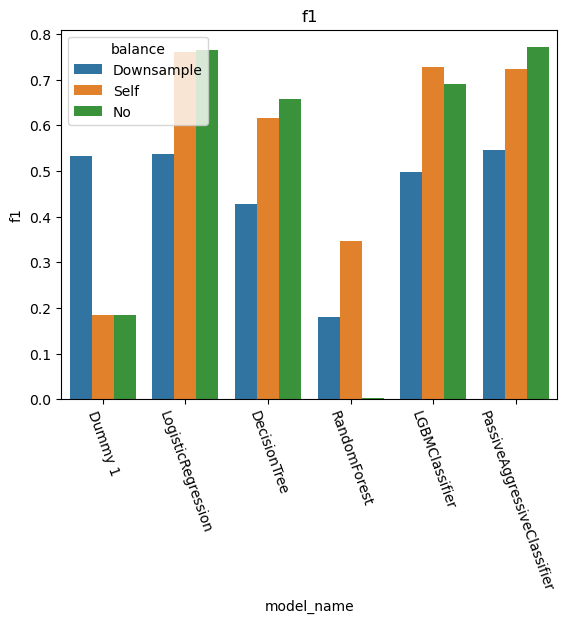

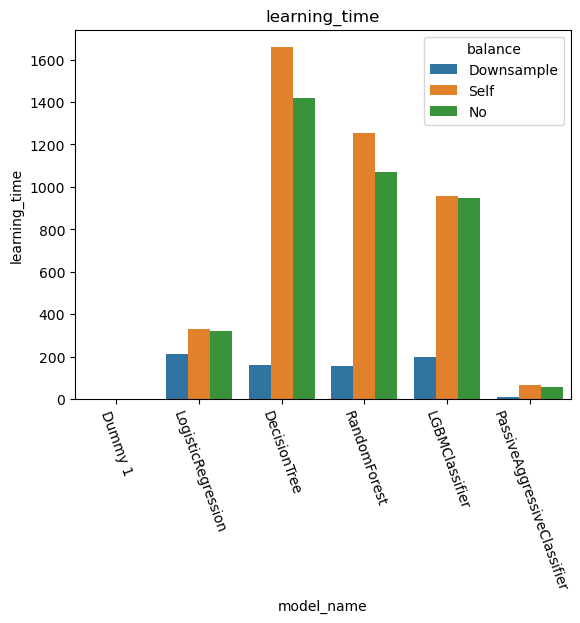

In [15]:
display(model_list.sort_values('f1'))

best_model_index = model_list['f1'].idxmax()
print('Index of the best model:', best_model_index)

def plot_models_parametr(parametr):
    """
    Function to compare parametrs
    """
    global model_list
    sns.barplot(data=model_list, x='model_name', y=parametr, hue='balance')
    plt.title(parametr)
    plt.ylabel(parametr)
    plt.xticks(rotation=-70)
    plt.show()
    
    return

plot_models_parametr('f1')
plot_models_parametr('learning_time')


### Validation on test sample and additional metrics

The best model is:
 model_name                             PassiveAggressiveClassifier
balance                                                         No
f1                                                        0.770526
comments                                           {'max_iter': 2}
model            GridSearchCV(cv=KFold(n_splits=5, random_state...
learning_time                                             56.84765
Name: 17, dtype: object 


Analysis for LogisticRegression


array([[27467,  1155],
       [  614,  2623]], dtype=int64)

Precision: 0.694
Recall: 0.81
F1: 0.748
accuracy: 0.944


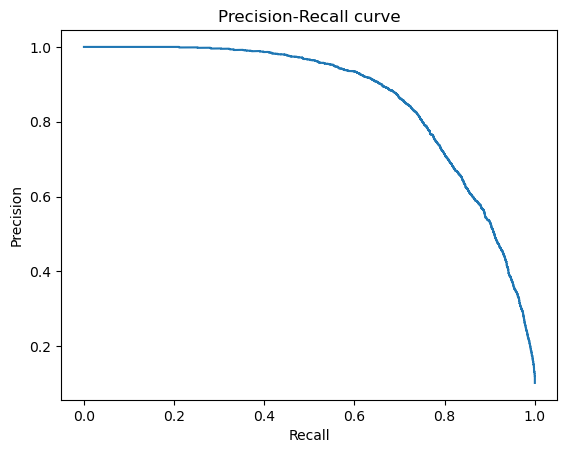

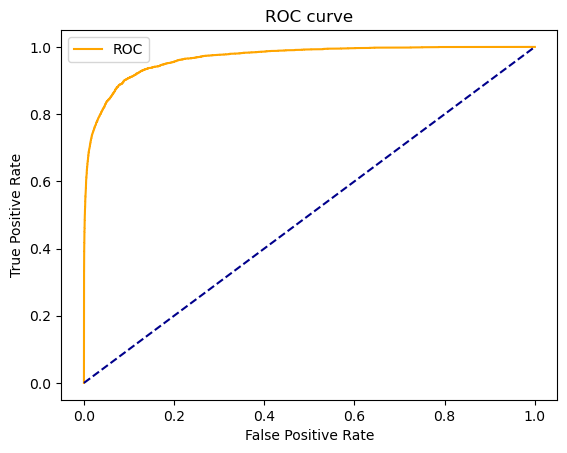

roc_auc_score: 0.967
{'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [17]:
print('The best model is:\n', model_list.loc[best_model_index], '\n\n')

predict_and_metrics_on_test(model_list.loc[4, 'model_name'],
                            model_list.loc[4, 'model'])

## Conclusions
Preliminary work has been done on the data - text cleaning and vectorization.
Several ML models were trained on the vectorized data, the best turned out to be linear model. Logistic regression and Passive-Agressive Algorithm both successfully met the customer's f1_score requirements on the test sample.
Random Forest, Decisive Tree and Busting models performed noticeably worse.